In [1]:
import glob
import aqdefreader as aqdr
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def load_data(data_folder_path: str) -> pd.DataFrame:
    data_file_paths = glob.glob(f"{data_folder_path}/*.dfq")
    data_file_paths = sorted(data_file_paths)
    data = defaultdict(list)

    for idx, path in enumerate(data_file_paths):
        if idx % 100 == 0:
            print(f"Processing file {idx+1}/{len(data_file_paths)}: {path}")
        try:
            dfq_data = aqdr.read_dfq_file(path)
            part: aqdr.part.Part = dfq_data.get_part(0)
            for characteristic in part.get_characteristics():
                data[characteristic.get_data('K2003')].extend([measurement.value for measurement in characteristic.get_measurements()])   
        
        except Exception as e:
            print(f"Error reading file {path}: {e}")
            continue

    return pd.DataFrame(data)


In [3]:
def calculate_bollinger_bands(data: pd.DataFrame, sigma_factor: float = 3, window: int = 50) -> pd.DataFrame:
    sma = data.rolling(window).mean()
    std_dev = data.rolling(window).std()
    bollinger = pd.DataFrame()
    bollinger['Upper'] = sma + sigma_factor * std_dev
    bollinger['Lower'] = sma - sigma_factor * std_dev
    return bollinger

def plot_data(parts_df: pd.DataFrame, sigma_factor: float, window:int = 50, start_at: int = 0, legend: bool = True) -> None:
    probe_cols = [f"Probe {i}" for i in range(1, 7)]
    track_cols = [f"Track {i}-{i+3}" for i in range(1, 4)]
    parts_df = parts_df[round(start_at*len(parts_df)):]

    # --- Probe Data Plotting and Statistics ---
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))  # 2 rows for line plots and histograms

    probe_stats = {}
    for i, probe in enumerate(probe_cols):
        data = parts_df[probe].dropna()
        mean = round(stats.describe(data).mean, 3)
        sigma_limits = round(sigma_factor * stats.describe(data).variance ** 0.5, 3)
        upper_limit = round(mean + sigma_limits, 3)
        lower_limit = round(mean - sigma_limits, 3)
        rolling_mean = data.rolling(window).mean()
        bollinger = calculate_bollinger_bands(data, sigma_factor, window)
        x_pos = int(i/3)*2
        y_pos = i%3

        # Line plot
        axes[x_pos, y_pos].plot(parts_df.index, parts_df[probe], label=None)
        axes[x_pos, y_pos].axhline(y=upper_limit, color='r', linestyle='--', label=f'{sigma_factor} σ Limits ({mean:.3f}±{sigma_limits:.3f})')
        axes[x_pos, y_pos].axhline(y=lower_limit, color='r', linestyle='--')
        axes[x_pos, y_pos].plot(parts_df.index, rolling_mean, color='black', label=f'Rolling Mean ({window})')
        axes[x_pos, y_pos].plot(parts_df.index, bollinger['Upper'], color='orange', label=f'{sigma_factor} σ Bollinger Bands ({window})')
        axes[x_pos, y_pos].plot(parts_df.index, bollinger['Lower'], color='orange')
        axes[x_pos, y_pos].set_title(probe)
        if legend:
            axes[x_pos, y_pos].legend()
        axes[x_pos, y_pos].grid(True)

        # Histogram
        axes[x_pos+1, y_pos].hist(data, bins=20, edgecolor='black')  # Adjust bins as needed
        axes[x_pos+1, y_pos].axvline(x=upper_limit, color='r', linestyle='--', label=f'Upper Limit ({upper_limit:.4f})')
        axes[x_pos+1, y_pos].axvline(x=lower_limit, color='r', linestyle='--', label=f'Lower Limit ({lower_limit:.4f})')
        axes[x_pos+1, y_pos].set_title(f'{probe} Histogram')
        axes[x_pos+1, y_pos].set_xlabel('Value')
        axes[x_pos+1, y_pos].set_ylabel('Frequency')

        probe_stats[probe] = {'Mean': mean, f'{sigma_factor}x Sigma': sigma_limits, 
                             'Upper Limit': upper_limit, 'Lower Limit': lower_limit}

    fig.suptitle("Probe Measurements", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlapping
    plt.show()
    probe_stats_df = pd.DataFrame(probe_stats).transpose()
    print(probe_stats_df)


    # --- Track Data Plotting and Statistics ---
    fig, axes = plt.subplots(2, len(track_cols), figsize=(15, 10), sharey='row') # Share y-axis within rows

    track_stats = {}
    for i, track in enumerate(track_cols):
        data = parts_df[track].dropna()
        mean = round(stats.describe(data).mean, 3)
        sigma_limits = round(sigma_factor * stats.describe(data).variance ** 0.5, 3)
        upper_limit = round(mean + sigma_limits, 3)
        lower_limit = round(mean - sigma_limits, 3)
        rolling_mean = data.rolling(window).mean()
        bollinger = calculate_bollinger_bands(data, sigma_factor, window)

        # Line plot
        axes[0, i].plot(parts_df.index, parts_df[track])
        axes[0, i].axhline(y=upper_limit, color='r', linestyle='--')
        axes[0, i].axhline(y=lower_limit, color='r', linestyle='--', label=f'{sigma_factor} σ Limits ({mean:.3f}±{sigma_limits:.3f})')
        axes[0, i].plot(parts_df.index, rolling_mean, color='black', label=f'Rolling Mean ({window})')
        axes[0, i].plot(parts_df.index, bollinger['Upper'], color='orange', label=f'{sigma_factor} σ Bollinger Bands ({window})')
        axes[0, i].plot(parts_df.index, bollinger['Lower'], color='orange')

        axes[0, i].set_title(track)
        if legend:
            axes[0, i].legend()
        axes[0, i].grid(True)

         # Histogram
        axes[1, i].hist(data, bins=20, edgecolor='black')
        axes[1, i].axvline(x=upper_limit, color='r', linestyle='--')
        axes[1, i].axvline(x=lower_limit, color='r', linestyle='--')
        axes[1, i].set_title(f'{track} Histogram')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Frequency')

        track_stats[track] = {'Mean': mean, f'{sigma_factor}x Sigma': sigma_limits, 
                              'Upper Limit': upper_limit, 'Lower Limit': lower_limit}

    fig.suptitle(f"Track Data with {sigma_factor} Sigma Limits", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

    track_stats_df = pd.DataFrame(track_stats).transpose()
    print(track_stats_df)



In [4]:
# Load the data
inners_path = "D:/promess ai pushpull/outers"
inners_df = load_data(inners_path)

Processing file 1/8892: D:/promess ai pushpull/outers\P(OR IXP19000_DL_rev00)_OP(IVL)_CS(IVL OuterRace [1])_TS(20250206184448052).dfq
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count of characteristics in DFQ file: 11
Count

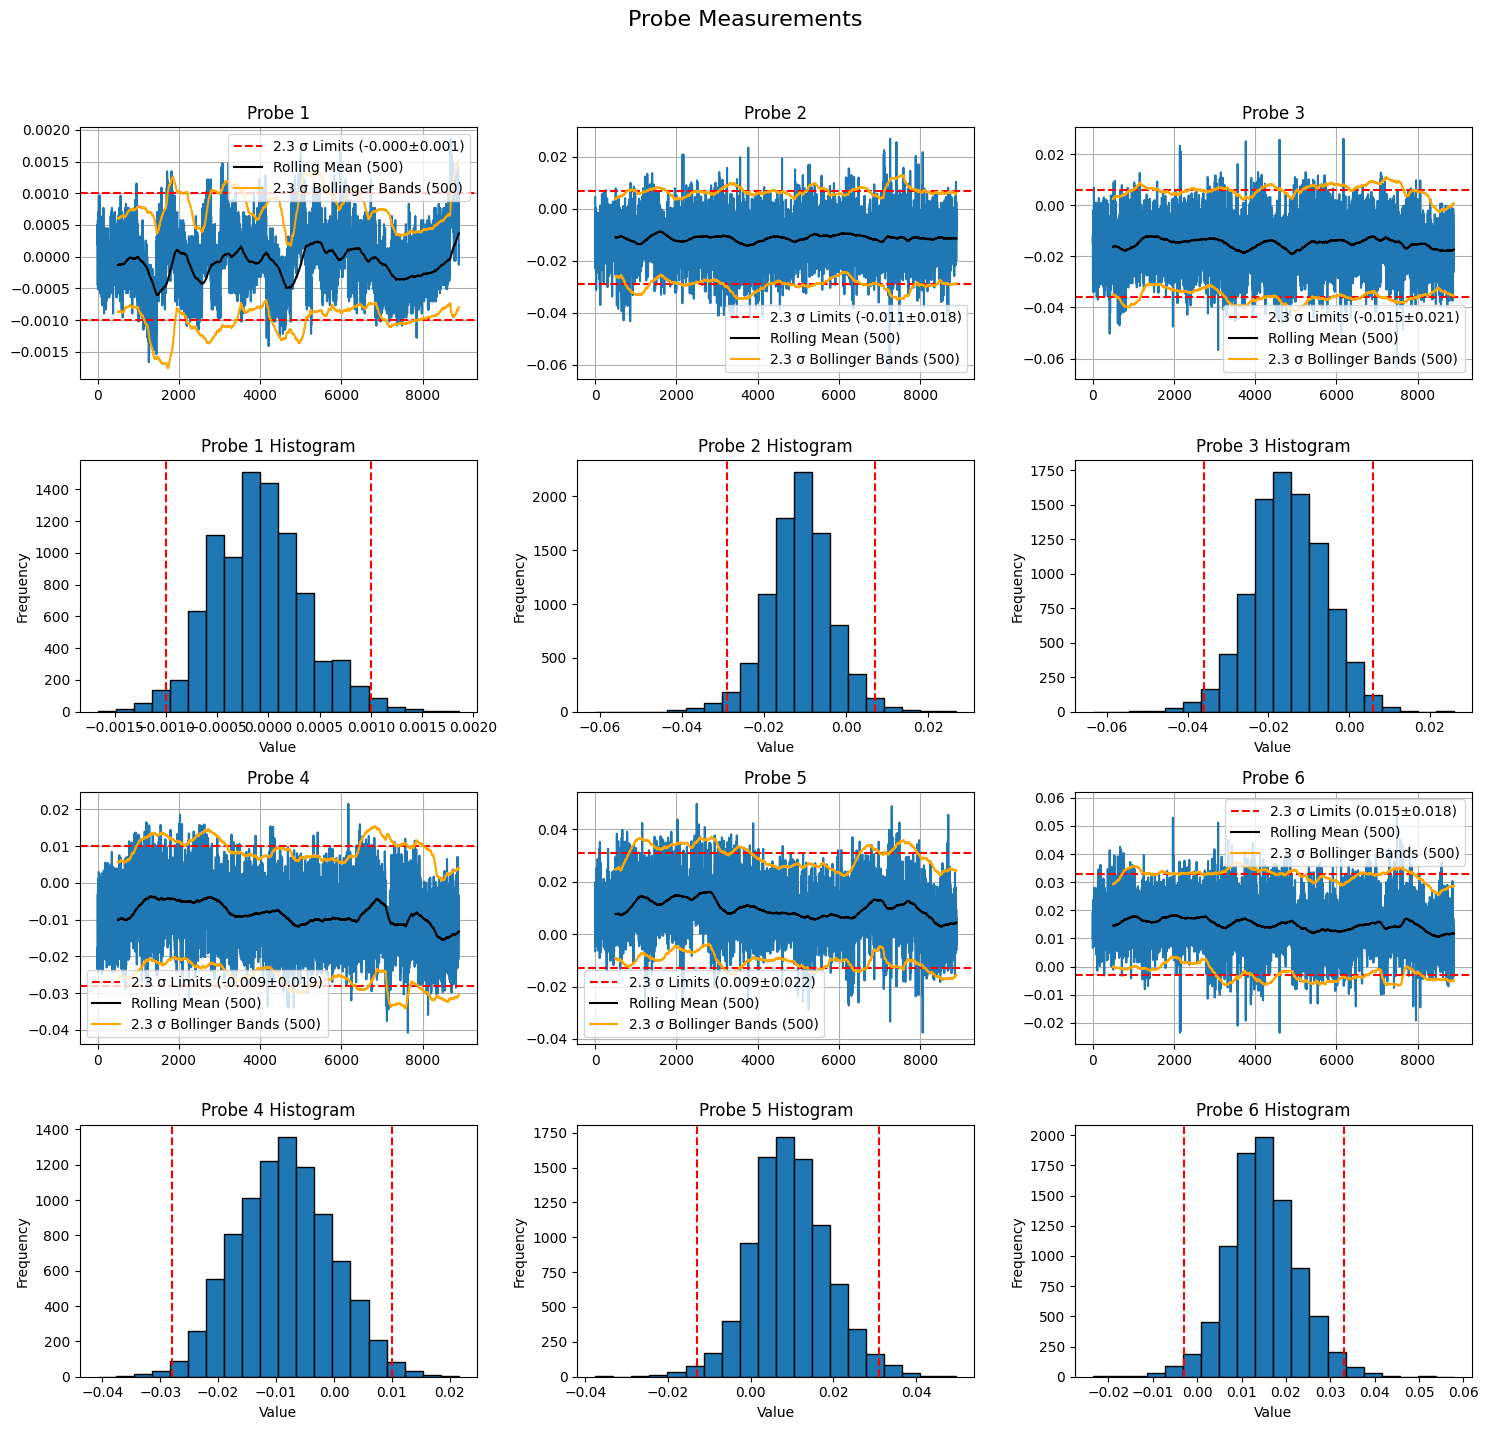

          Mean  2.3x Sigma  Upper Limit  Lower Limit
Probe 1 -0.000       0.001        0.001       -0.001
Probe 2 -0.011       0.018        0.007       -0.029
Probe 3 -0.015       0.021        0.006       -0.036
Probe 4 -0.009       0.019        0.010       -0.028
Probe 5  0.009       0.022        0.031       -0.013
Probe 6  0.015       0.018        0.033       -0.003


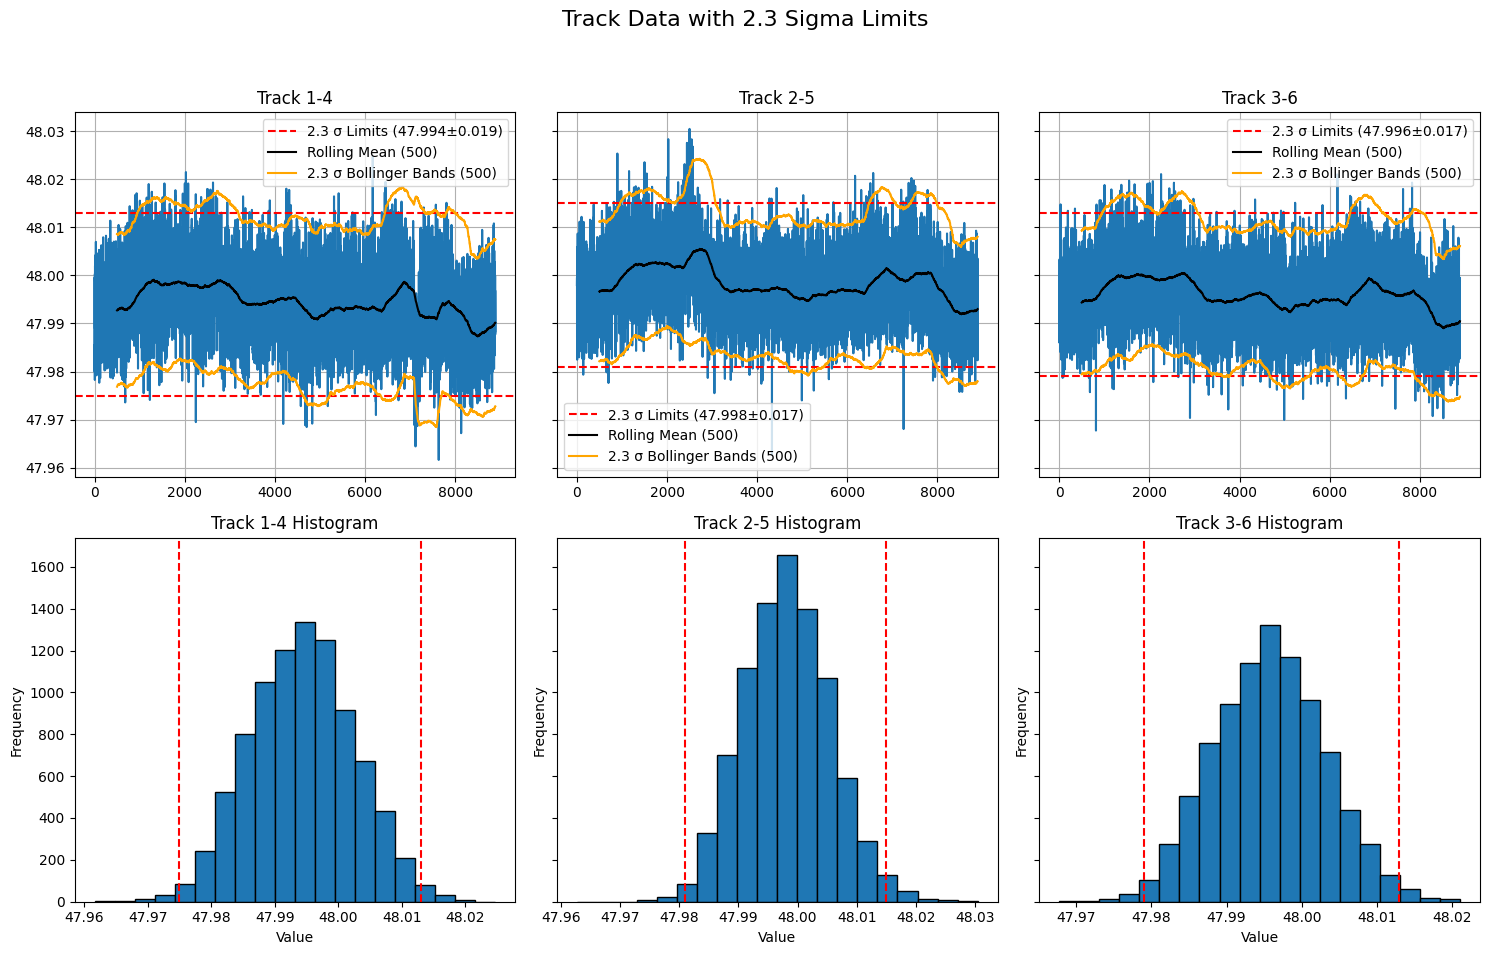

             Mean  2.3x Sigma  Upper Limit  Lower Limit
Track 1-4  47.994       0.019       48.013       47.975
Track 2-5  47.998       0.017       48.015       47.981
Track 3-6  47.996       0.017       48.013       47.979


In [5]:
# Plot the data
plot_data(inners_df, sigma_factor=2.3, window=500, start_at=0, legend=True)

In [6]:
inners_df.head()

,average PCD,Track 1-4,Track 2-5,Track 3-6,Probe 1,Probe 2,Probe 3,Probe 4,Probe 5,Probe 6,Temp delta to cal
0,47.990965,47.985480,47.998000,47.988288,0.000192,0.004472,-0.014515,-0.017776,-0.006472,0.006740,-0.032018
1,47.989439,47.980046,47.994484,47.992722,0.000513,-0.008815,-0.022544,-0.023467,0.003363,0.019266,0.006405
2,47.997500,47.996669,47.999580,47.995059,-0.000256,-0.005877,-0.011368,-0.006075,0.005457,0.010364,-0.012806
3,47.986147,47.984263,47.987170,47.986009,-0.000449,-0.011435,-0.019975,-0.018352,-0.001459,0.009919,-0.025615
4,47.996064,47.999610,47.996863,47.990782,-0.000256,-0.022933,-0.025819,-0.003133,0.019860,0.020601,-0.076844
